# Introduction to regressions with with Scikit-learn

<a rel="license" href="https://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Authors**:
- Dr Antonia Mey (antonia.mey@ed.ac.uk)

Content is partially adapted from the Andrew Whites book on [Machine learning](https://dmol.pub/ml/regression.html#exploring-effect-of-feature-number) and [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html).

**Questions:**
- How can we cast a linear regression problem as a machine learning problem

**Objectives:**
- Learn how to split data in to train, validation and test data.
- Fit a linear regression model
- Get an understanding of overfitting and underfitting data

**Jupyter cheat sheet**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

## Google Colab installs

<div class="alert alert-warning">
The following cell install necessary packages and downloads data if you are running this tutorial using Google Colab.<br>
<b><i>Run this cell only if you are using Google Colab!</i></b></div>

In [ ]:
!if [ -n "$COLAB_RELEASE_TAG" ]; then git clone https://github.com/Edinburgh-Chemistry-Teaching/ATCP-ML-workshop; fi
import os
os.chdir(f"ATCP-ML-workshop{os.sep}Workshops{os.sep}workshop_01")

## 1. Introduction to regression models

The objective is to train a model to learn the relation between data points. We will be looking at splitting data, learning a relationship between data and see how we can evaluate how good or bad a model has learned the data. For this purpose, we will be looking at how the loss changes over time during training.

### 1.1. Using a linear model to fit data generated from a polynomial function

The real function we're trying to learn will be:

\begin{equation}
 f(x) = x^3 - x^2 + x - 1
\end{equation}

which we can rewrite as a linear model:

\begin{equation}
  f(\vec{x}) = \vec{w}\cdot\vec{x} = [1, -1, 1, -1]\cdot[x^3, x^2, x, 1]
\end{equation}
where our features are $[x^3, x^2, x, 1]$. To do our split, we'll randomly pick 30 % of the data as test data points. To avoid the issue of convergence, we will use least squares to fit these models instead of gradient descent.

In [1]:
import numpy as np
# generate data from polynomial
N = 20
syn_x = np.linspace(-3, 3, N)
# create feature matrix these are our x values
syn_features = np.vstack([syn_x**3, syn_x**2, syn_x, np.ones_like(syn_x)]).T
# Here our labels are just the y values of the function
syn_labels = syn_x**3 - syn_x**2 + syn_x - 1

We have no generated model data.
Next let's see how we can split this data.

### 1.2. Splitting data into training, testing, (and validation)

In [2]:
import matplotlib.pylab as plt

Splitting your dataset is essential for an unbiased evaluation of prediction performance. In most cases, it’s enough to split your dataset randomly into three subsets:

- The training set is applied to train or fit your model. For example, you use the training set to find the optimal weights, or coefficients, for linear regression, logistic regression, or neural networks.

- The validation set is used for unbiased model evaluation during hyperparameter tuning. For example, when you want to find the optimal number of neurons in a neural network or the best kernel for a support vector machine, you experiment with different values. For each considered setting of hyperparameters, you fit the model with the training set and assess its performance with the validation set.

- The test set is needed for an unbiased evaluation of the final model. You shouldn’t use it for fitting or validation.

In less complex cases, when you don’t have to tune hyperparameters, it’s okay to work with only the training and test sets, this is the case we will be looking at here.



In [3]:
# split data into train/test using scikit learn
from sklearn.model_selection import train_test_split

Now that you have imported the appropriate part from scikit learn, you can use them to split data into training sets and test sets. You’ll split inputs and outputs at the same time, with a single function call.

With `train_test_split()`, you only need to provide the arrays that you want to split. Additionally, you can also provide some optional arguments. The function usually returns a list of NumPy arrays.

The arrays parameter in the function signature of train_test_split() refers to the sequence of lists, NumPy arrays, pandas DataFrames, or similar array-like objects that hold the data that you want to split. All these objects together make up the dataset and must be of the same length.

In supervised machine learning applications, you’ll typically work with two such arrays:

1. A two-dimensional array with the inputs (x)
2. A one-dimensional array with the outputs (y)

The options parameter indicates that you can customize the function’s behaviour with optional keyword arguments:

`train_size` is the number that defines the size of the training set. If you provide a `float`, then it must be between 0.0 and 1.0 and it will define the share of the dataset used for testing. If you provide an `int`, then it will represent the total number of the training samples. The default value is `None`.

`test_size` is the number that defines the size of the test set. It’s very similar to `train_size`. You should provide either `train_size` or `test_size`. If neither is given, then the default share of the dataset that will be used for testing is 0.25, or 25 percent.

`random_state` is the object that controls randomization during splitting. It can be either an int or an instance of RandomState. Setting the random state is useful if you need reproducibility. The default value is None.

`shuffle` is the Boolean object that determines whether to shuffle the dataset before applying the split. The default value is True.

`stratify` is an array-like object that, if not None, determines how to use a stratified split.

You can think of the splitting of data looking like this:

![alt text](https://github.com/Edinburgh-Chemistry-Teaching/ATCP-ML-workshop/blob/main/Workshops/workshop_01/images/data_split.png?raw=1)

Now it’s time to try data splitting!

In [4]:
indices = np.arange(len(syn_features))
x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(
    syn_features, syn_labels,indices, test_size=0.33, random_state=42)

Now let's plot the data to understand what we have done in terms of splitting the data according to test and train.

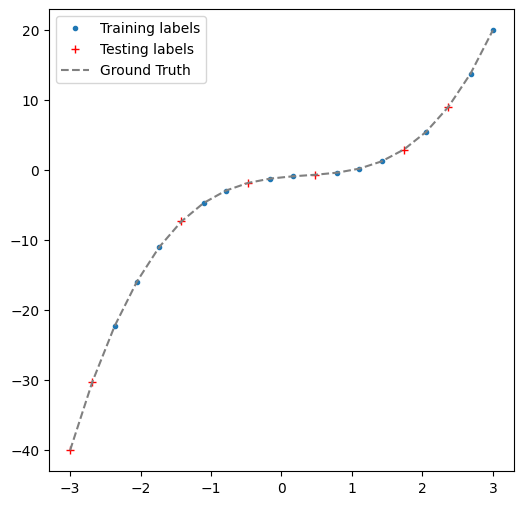

In [5]:
# plotting code
figure = plt.figure(figsize=(6,6))
plt.plot(syn_x[train_idx], y_train, ".", label="Training labels")
plt.plot(syn_x[test_idx], y_test, "+", label="Testing labels", color='red')
plt.plot(syn_x, syn_labels, "--", label="Ground Truth", color='grey')
plt.legend()


### 1.3. Training the model

First we will need to import the linear regression model

In [6]:
from sklearn.linear_model import LinearRegression

Next we will need to import the metrics that tell us how well we are doing.
We want to use the mean square error and the coefficient of determination for this.
Scikit learn conveniently provides tools for this, so nothing needs to be implemented.

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

The `r2_score` is the coefficient of determination and tells you something about the goodness of fit.
The `mean_square_error` is what we termed loss before and gives you information on how 'right' or 'wrong' your model is at predicting the data.

The steps taken to actually run a linear regression are generally always the same:
1. Import the classes you need.
2. Create model instances using these classes.
3. Fit the model instances with `.fit()` using the training set.
4. Evaluate the model with `metrics`, or directly with `.score()` using the test set.
While here we only look at one algorithm for LinearRegressions, there are many different options in scikit learn.

In [8]:
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set and training set to work out the loss from the mean square error
y_pred_test = regr.predict(x_test)
y_pred_train = regr.predict(x_train)

# The mean squared error that will give you the loss
training_loss = mean_squared_error(syn_labels[train_idx], y_pred_train)
test_loss = mean_squared_error(syn_labels[test_idx], y_pred_test)


# The coefficient of determination: 1 is a perfect prediction and gives you an idea of the goodness of fit of the model
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_test))

# The coefficients these are the coefficients you have successfully fit the model with
print("Coefficients: \n", regr.coef_)


Coefficient of determination: 1.00
Coefficients: 
 [ 1. -1.  1.  0.]


Now we have done all the fitting and work, lets see what the model has done.

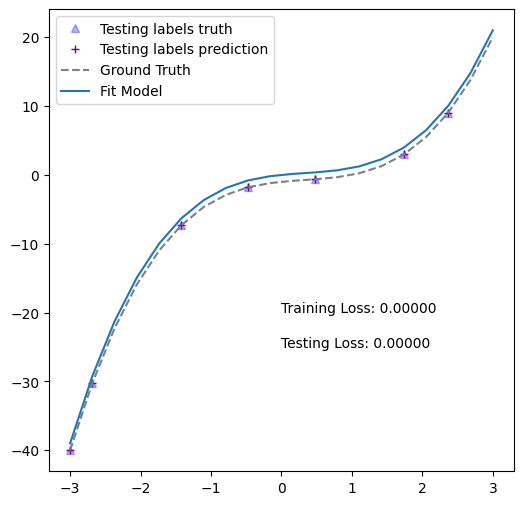

In [9]:
# Plot outputs
figure = plt.figure(figsize=(6,6))
plt.plot(syn_x[test_idx], y_test, "^", label="Testing labels truth", color='blue', alpha=0.3)
plt.plot(syn_x[test_idx], y_pred_test, "+", label="Testing labels prediction", color='purple')
plt.plot(syn_x, syn_labels, "--", label="Ground Truth", color='grey')
plt.plot(syn_x, np.dot(syn_features, regr.coef_), label="Fit Model")
plt.text(0, -20, f"Training Loss: {training_loss:.5f}")
plt.text(0, -25, f"Testing Loss: {test_loss:.5f}")
plt.legend()

### 1.4. Task section

<div class="alert alert-success">
<b>Task 1: Discuss with your colleague </b>
<p>
    What are the assumptions made for this regression model example that make everything work really well?
</p>
</div>

<details>
<summary> <mark> Solution: Some assumptions that were made</mark> </summary>

Assumptions:
- The data does fit a linear model
- Random split gives a good distribution of data points
- The number of parameters you are trying to fit indicates that you have an idea of the functional form


</details>

<div class="alert alert-success">
<b>Task 2: How does the data splitting for training and test your prediction when you add noise to the data </b> </div>

Using the same random split as before and just adding noise to the data, how does the model perform? What do you observe?

You can make your model noisy in the following way
```Python

train_y = train_y + np.random.normal(scale=5, size=train_y.shape)

```


Coefficient of determination: 0.97
Coefficients: 
 [ 0.87632378 -1.4020762   1.55607995  0.        ]


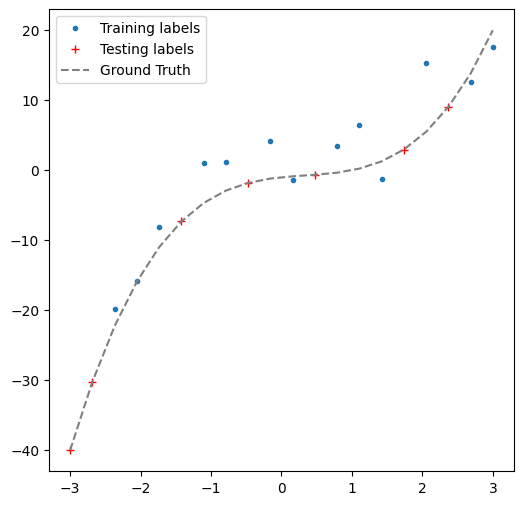

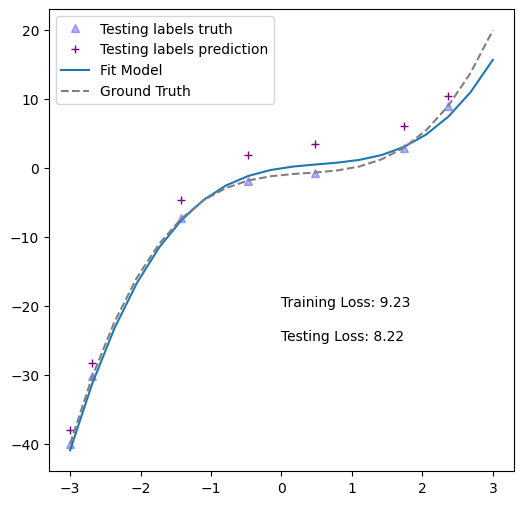

In [10]:
### Your solution here! ###
y_train_noise = y_train + np.random.normal(scale=5, size=y_train.shape)

# Let's plot the data with the random noise
figure = plt.figure(figsize=(6,6))
plt.plot(syn_x[train_idx], y_train_noise, ".", label="Training labels")
plt.plot(syn_x[test_idx], y_test, "+", label="Testing labels", color='red')
plt.plot(syn_x, syn_labels, "--", label="Ground Truth", color='grey')
plt.legend()

# Now let's do the training again
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train_noise)

# Make predictions using the testing set and training set to work out the loss from the mean square error
y_pred_test = regr.predict(x_test)
y_pred_train = regr.predict(x_train)

# The mean squared error that will give you the loss
training_loss = mean_squared_error(syn_labels[train_idx], y_pred_train)
test_loss = mean_squared_error(syn_labels[test_idx], y_pred_test)


# The coefficient of determination: 1 is a perfect prediction and gives you an idea of the goodness of fit of the model
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_test))

# The coefficients these are the coefficients you have successfully fit the model with
print("Coefficients: \n", regr.coef_)

# Plot outputs
figure = plt.figure(figsize=(6,6))
plt.plot(syn_x[test_idx], y_test, "^", label="Testing labels truth", color='blue', alpha=0.3)
plt.plot(syn_x[test_idx], y_pred_test, "+", label="Testing labels prediction", color='purple')
plt.plot(syn_x, np.dot(syn_features, regr.coef_), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth", color='grey')
plt.text(0, -20, f"Training Loss: {training_loss:.2f}")
plt.text(0, -25, f"Testing Loss: {test_loss:.2f}")
plt.legend()

<details>
<summary> <mark> Solution</mark> </summary>

```Python
y_train_noise = y_train + np.random.normal(scale=5, size=y_train.shape)

# Let's plot the data with the random noise
figure = plt.figure(figsize=(6,6))
plt.plot(syn_x[train_idx], y_train_noise, ".", label="Training labels")
plt.plot(syn_x[test_idx], y_test, "+", label="Testing labels", color='red')
plt.plot(syn_x, syn_labels, "--", label="Ground Truth", color='grey')
plt.legend()

# Now let's do the training again
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train_noise)

# Make predictions using the testing set and training set to work out the loss from the mean square error
y_pred_test = regr.predict(x_test)
y_pred_train = regr.predict(x_train)

# The mean squared error that will give you the loss
training_loss = mean_squared_error(syn_labels[train_idx], y_pred_train)
test_loss = mean_squared_error(syn_labels[test_idx], y_pred_test)


# The coefficient of determination: 1 is a perfect prediction and gives you an idea of the goodness of fit of the model
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_test))

# The coefficients these are the coefficients you have successfully fit the model with
print("Coefficients: \n", regr.coef_)

# Plot outputs
figure = plt.figure(figsize=(6,6))
plt.plot(syn_x[test_idx], y_test, "^", label="Testing labels truth", color='blue', alpha=0.3)
plt.plot(syn_x[test_idx], y_pred_test, "+", label="Testing labels prediction", color='purple')
plt.plot(syn_x, np.dot(syn_features, regr.coef_), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth", color='grey')
plt.text(0, -20, f"Training Loss: {training_loss:.2f}")
plt.text(0, -25, f"Testing Loss: {test_loss:.2f}")
plt.legend()
```
</details>

## 2. Overfitting and underfitting your data

Splitting a dataset might also be important for detecting if your model suffers from one of two very common problems, called underfitting and overfitting:

- Underfitting is usually the consequence of a model being unable to encapsulate the relations among data. For example, this can happen when trying to represent nonlinear relations with a linear model. Underfitted models will likely have poor performance with both training and test sets.

- Overfitting usually takes place when a model has an excessively complex structure and learns both the existing relations among data and noise. Such models often have bad generalization capabilities. Although they work well with training data, they usually yield poor performance with unseen test data.

You can find a more detailed explanation of underfitting and overfitting in [Linear Regression](https://realpython.com/linear-regression-in-python/#underfitting-and-overfitting) in Python.

## 2.1 Task section

<div class="alert alert-success">
<b>Task 1: Take a look at how you split your data: </b>
</div>

- Try splitting using only the first 6 data points for training
- Try using only the first 6 and last 6 data points for training   
What do you observe?


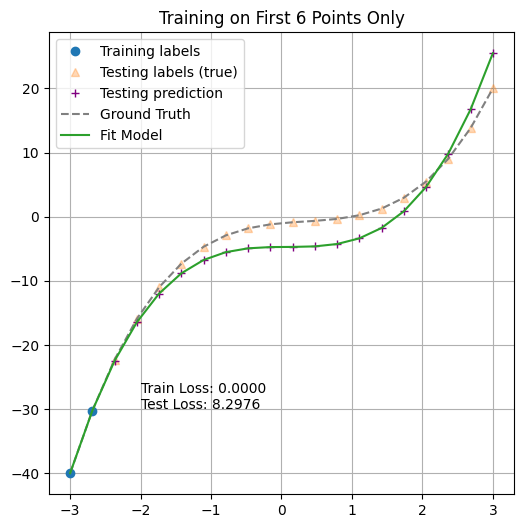

Training on First 6 Points Only
R2 score on test set: 0.91
Coefficients: [ 1.20721251 -0.28288227  0.04976633  0.        ]
Intercept: -4.710022850175349
----------------------------------------


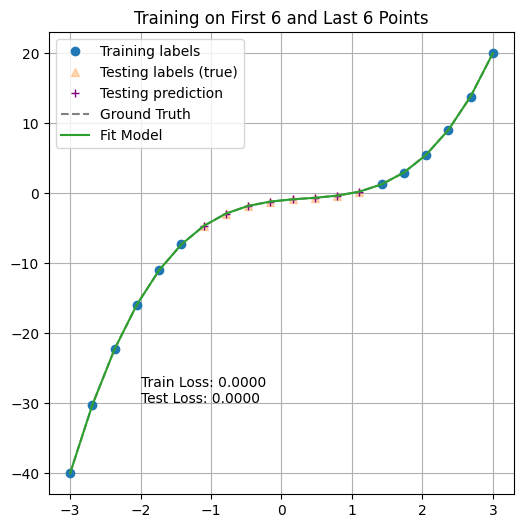

Training on First 6 and Last 6 Points
R2 score on test set: 1.00
Coefficients: [ 1. -1.  1.  0.]
Intercept: -1.0000000000000009
----------------------------------------


In [12]:
# Strategy 1: Only the first 6 points
train_idx_1 = np.arange(2)
test_idx_1 = np.setdiff1d(np.arange(N), train_idx_1)

# Strategy 2: First 6 and last 6 points
train_idx_2 = np.concatenate([np.arange(6), np.arange(N-6, N)])
test_idx_2 = np.setdiff1d(np.arange(N), train_idx_2)

def run_and_plot(train_idx, test_idx, title):
    x_train = syn_features[train_idx]
    y_train = syn_labels[train_idx]
    x_test = syn_features[test_idx]
    y_test = syn_labels[test_idx]

    # Regression
    regr = LinearRegression()
    regr.fit(x_train, y_train)

    # Predictions
    y_pred_test = regr.predict(x_test)
    y_pred_train = regr.predict(x_train)

    # Errors
    training_loss = mean_squared_error(y_train, y_pred_train)
    test_loss = mean_squared_error(y_test, y_pred_test)

    # Plot
    plt.figure(figsize=(6,6))
    plt.plot(syn_x[train_idx], y_train, "o", label="Training labels")
    plt.plot(syn_x[test_idx], y_test, "^", label="Testing labels (true)", alpha=0.3)
    plt.plot(syn_x[test_idx], y_pred_test, "+", label="Testing prediction", color='purple')
    plt.plot(syn_x, syn_labels, "--", label="Ground Truth", color='grey')
    plt.plot(syn_x, np.dot(syn_features, regr.coef_) + regr.intercept_, label="Fit Model")
    plt.title(title)
    plt.text(-2, -30, f"Train Loss: {training_loss:.4f}\nTest Loss: {test_loss:.4f}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print metrics
    print(title)
    print("R2 score on test set: %.2f" % r2_score(y_test, y_pred_test))
    print("Coefficients:", regr.coef_)
    print("Intercept:", regr.intercept_)
    print("-" * 40)

# Run both strategies
run_and_plot(train_idx_1, test_idx_1, "Training on First 6 Points Only")
run_and_plot(train_idx_2, test_idx_2, "Training on First 6 and Last 6 Points")

### Next Notebook

[Application](03_application.ipynb)

-----